In [24]:
from google.colab import drive
drive.mount('/content/drive/')

folder_name = '/content/drive/Shareddrives/space/colab-content/credit-card-fraud-detection'

%cd $folder_name

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/Shareddrives/space/colab-content/credit-card-fraud-detection


# Credit Card Fraud Detection

In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [26]:
data = pd.read_csv('./application_data.csv')
data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
data = data.iloc[np.random.randint(0, len(data), size= 10000), :]

## Data Cleaning

### Handling missing data

In [28]:
## dropping of the columns in which more than 50 percent of the data is missing
columns_to_drop = data.columns[data.isna().mean()* 100 > 50 ]
data.drop(columns= columns_to_drop, inplace= True)

In [29]:
## replacing missing values with mean and mode
missing_data_column_names = data.columns[data.isna().any()]
missing_number_data_columns = data[missing_data_column_names].select_dtypes(include= 'number')
missing_object_data_columns = data[missing_data_column_names].select_dtypes(include= 'object')

missing_number_data_columns.fillna(value= missing_number_data_columns.mean(), inplace= True)
missing_object_data_columns.fillna(value= missing_object_data_columns.mode().loc[0, :], inplace= True)

data[missing_number_data_columns.columns] = missing_number_data_columns
data[missing_object_data_columns.columns] = missing_object_data_columns

In [30]:
print(f'No. of na in data: {data.isna().sum().sum()}')
print(f'shape of data: {data.shape}')

No. of na in data: 0
shape of data: (10000, 81)


There are no missing vaues in any of the columns as show above

### Encoding categorical data

In [31]:
categorical_column_names = data.select_dtypes(include= 'object').columns

categorical_columns = data[categorical_column_names]
encoded_data = pd.get_dummies(categorical_columns)

data.drop(columns= categorical_column_names, inplace= True)
data = pd.concat([data, encoded_data], axis= 1)

print(f'Shape of data: {data.shape}')

Shape of data: (10000, 191)


In [32]:
data.isna().sum()

SK_ID_CURR                             0
TARGET                                 0
CNT_CHILDREN                           0
AMT_INCOME_TOTAL                       0
AMT_CREDIT                             0
                                      ..
ORGANIZATION_TYPE_Transport: type 4    0
ORGANIZATION_TYPE_University           0
ORGANIZATION_TYPE_XNA                  0
EMERGENCYSTATE_MODE_No                 0
EMERGENCYSTATE_MODE_Yes                0
Length: 191, dtype: int64

### Handling data imbalance

In [33]:
data['TARGET'].value_counts()

0    9210
1     790
Name: TARGET, dtype: int64

As we can see the data is highly imbalance. So, lets upsample the minority class data

In [34]:
from sklearn.utils import resample

# upsampling the minority calss data
majority_class_data = data[data['TARGET'] == 0]
minority_class_data = data[data['TARGET'] == 1]

upsampled_minority_class_data = resample(minority_class_data, replace= True, n_samples= len(majority_class_data))

data = pd.concat([majority_class_data, upsampled_minority_class_data], axis= 0)
data.reset_index()

data['TARGET'].value_counts()

0    9210
1    9210
Name: TARGET, dtype: int64



### Splitting data

In [35]:
from sklearn.model_selection import train_test_split

X = data.drop(columns = 'TARGET')
y = data['TARGET']


print(f'shape of X: {X.shape}')
print(f'shape of y: {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state= 42)

print(f'shape of X_train: {X_train.shape}')
print(f'shape of y_train: {y_train.shape}')
print(f'shape of X_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')

shape of X: (18420, 190)
shape of y: (18420,)
shape of X_train: (16578, 190)
shape of y_train: (16578,)
shape of X_test: (1842, 190)
shape of y_test: (1842,)


## TSNE

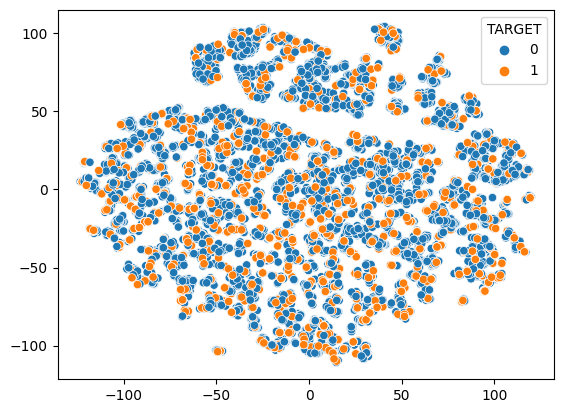

In [36]:
from sklearn.manifold import TSNE


X_train_embedded = TSNE(n_jobs= -1).fit_transform(X_train)

sns.scatterplot(x= X_train_embedded[:, 0], y= X_train_embedded[:, 1], hue= y_train)

plt.show()

## KNN

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


clf = KNeighborsClassifier(n_neighbors=3, n_jobs= -1)


In [54]:
clf.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

In [55]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

In [56]:
accuracy_score(y_train, train_pred)

0.9574737604053565

In [57]:
accuracy_score(y_test, test_pred)

0.9087947882736156

In [58]:
confusion_matrix(y_train, train_pred)

array([[7554,  704],
       [   1, 8319]])

In [59]:
confusion_matrix(y_test, test_pred)

array([[784, 168],
       [  0, 890]])

In [62]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       952
           1       0.84      1.00      0.91       890

    accuracy                           0.91      1842
   macro avg       0.92      0.91      0.91      1842
weighted avg       0.92      0.91      0.91      1842



## Naive Bayes Model

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix

clf = GaussianNB()

clf.fit(X_train, y_train)

In [ ]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

In [ ]:
confusion_matrix(y_train, train_pred)

In [ ]:
confusion_matrix(y_test, test_pred)

## SVM

In [ ]:
from sklearn.svm import SVC

linear_svm = SVC(kernal= 'linear', random_state= 10)

linear_svm.fit(X_train, y_train)

test_predictions = linear_svm.predict(X_test)




